<a href="https://colab.research.google.com/github/mezlet/PPI-Inhibitors/blob/main/code/svmreadfromfile_generate_prediction_binders_and_random_both_as_negative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set the Runtime->Change Runtime Type to GPU**

# Protein 3d structure assessment with graph neural networks

In [1]:
#!rm -r Data
!rm -r PPI-Inhibitors
!git clone https://github.com/adibayaseen/PPI-Inhibitors
#!pip install py3Dmol

rm: cannot remove 'PPI-Inhibitors': No such file or directory
Cloning into 'PPI-Inhibitors'...
remote: Enumerating objects: 1341, done.
remote: Total 1341 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 1)
Receiving objects: 100% (1341/1341), 2.59 GiB | 53.14 MiB/s, done.
Resolving deltas: 100% (417/417), done.
Updating files: 100% (605/605), done.


In [2]:
!pip install --upgrade pip setuptools wheel
!pip install rdkit biopython==1.81 torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 torch-geometric==2.5.3 tqdm==4.66.2 pandas==2.1.4 numpy==1.26.4 scikit-learn==1.3.2 matplotlib==3.8.3 seaborn==0.13.2 networkx==3.2.1 gdown


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 79.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 44.9 MB/s  0:00:08
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 131.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 93.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 153.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 133.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 101.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 57.8 MB/s  0:00:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 76.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 58.2 MB/s  0:00:00
   ━━━━━━━━━━━

In [1]:
%cd PPI-Inhibitors
!mkdir -p Data

%cd Data
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/01ad4975fb9133825b1bf9e71b64fcdaaa5e4d8b/Data/2p2iComplexPairs.txt
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/01ad4975fb9133825b1bf9e71b64fcdaaa5e4d8b/Data/2p2iInhibitorsSMILES.txt
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/2d6bd03422602ec19147870c487e64018b52660f/Data/WriteAllexamplesRandomBindersIdsAll_24JAN_Binary.txt
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/b1e45884f61f792399abad2e4492f48083ab1093/Data/BindersWithComplexname.csv
%cd ..

/content/PPI-Inhibitors
/content/PPI-Inhibitors/Data
/content/PPI-Inhibitors


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.2.2+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 78.2 MB/s  0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 65.6 MB/s  0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.1 MB/s  0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 946.2/946.2 kB 5.1 MB/s  0:00:00


In [4]:
#Compound part
!pip install kora
import kora.install.rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [kora]


/usr/local/lib/python3.12/dist-packages/kora/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [5]:
!wget -qO- https://micro.mamba.pm/install.sh | bash


Running `shell init`, which:
 - modifies RC file: "/root/.bashrc"
 - generates config for root prefix: "/root/micromamba"
 - sets mamba executable to: "/root/.local/bin/micromamba"
The following has been added in your "/root/.bashrc" file

# >>> mamba initialize >>>
# !! Contents within this block are managed by 'micromamba shell init' !!
export MAMBA_EXE='/root/.local/bin/micromamba';
export MAMBA_ROOT_PREFIX='/root/micromamba';
__mamba_setup="$("$MAMBA_EXE" shell hook --shell bash --root-prefix "$MAMBA_ROOT_PREFIX" 2> /dev/null)"
if [ $? -eq 0 ]; then
    eval "$__mamba_setup"
else
    alias micromamba="$MAMBA_EXE"  # Fallback on help from micromamba activate
fi
unset __mamba_setup
# <<< mamba initialize <<<

Please restart your shell to activate micromamba or run the following:\n
  source ~/.bashrc (or ~/.zshrc, ~/.xonshrc, ~/.config/fish/config.fish, ...)


In [6]:
import os
os.environ["PATH"] += ":/root/.local/bin:/root/micromamba/bin"


In [7]:
!micromamba --version


2.3.3


In [8]:
!micromamba create -y -n bioenv -c conda-forge -c bioconda biopython
!micromamba run -n bioenv python -c "import Bio; print('BioPython version:', Bio.__version__)"


[+] 0.0s
[+] 0.1s
bioconda/linux-64 ..  ⣾  
bioconda/noarch (c..  ⣾  
nodefaults/linux-6..  ⣾  
nodefaults/noarch ..  ⣾  [+] 0.2s
nodefaults/linux-6..  ⣾  
nodefaults/noarch ..  ⣾  [+] 0.3s
nodefaults/noarch ..  ⣾  [+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  
bioconda/linux-64     ⣾  
bioconda/noarch       ⣾  
nodefaults/linux-64   ⣾  [+] 0.2s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  
bioconda/linux-64      8%
bioconda/noarch       13%
nodefaults/linux-64   ⣾  bioconda/noarch                                   
nodefaults/linux-64                               
[+] 0.3s
conda-forge/linux-64   1%
conda-forge/noarch     4%
bioconda/linux-64     19%
nodefaults/noarch     ⣾  nodefaults/noarch                                 
[+] 0.4s
conda-forge/linux-64  11%
conda-forge/noarch    22%
bioconda/linux-64     78%bioconda/linux-64                                 
[+] 0.5s
conda-forge/linux-64  19%
conda-forge/noarch    51%[+] 0.6s
conda-forge/linux-64  19%
con

In [9]:
from rdkit import Chem

/usr/local/lib/python3.12/dist-packages/Bio/PDB/Polypeptide.py:161: BiopythonDeprecationWarning: 'one_to_three' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_1to3'.
  warnings.warn(


Successfully loaded 956 inhibitors from 2p2iInhibitorsSMILES.txt


100%|██████████| 956/956 [00:00<00:00, 702356.74it/s]
[20:51:08] Explicit valence for atom # 35 N, 4, is greater than permitted
[20:51:08] Explicit valence for atom # 25 N, 4, is greater than permitted
[20:51:08] Explicit valence for atom # 18 N, 4, is greater than permitted
[20:51:08] DEPRECATION WARNING: please use MorganGenerator
[20:51:08] DEPRECATION WARNING: please use MorganGenerator
[20:51:08] Explicit valence for atom # 21 N, 4, is greater than permitted
[20:51:08] DEPRECATION WARNING: please use MorganGenerator
[20:51:08] Explicit valence for atom # 37 N, 4, is greater than permitted
[20:51:08] Explicit valence for atom # 47 N, 4, is greater than permitted
[20:51:08] Explicit valence for atom # 35 N, 4, is greater than permitted
[20:51:08] Explicit valence for atom # 35 N, 4, is greater than permitted
[20:51:08] Explicit valence for atom # 18 N, 4, is greater than permitted
[20:51:08] Explicit valence for atom # 18 N, 4, is greater than permitted
[20:51:08] Explicit valence f

Testlen 1619 train length 9759
2XA0_A_2_B 	 0.706 	 0.011


100%|██████████| 24/24 [00:00<00:00, 272800.26it/s]
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:51:18] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.708 0.48


100%|██████████| 28/28 [00:00<00:00, 163338.68it/s]
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use MorganGenerator
[20:51:19] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 1481 train length 9897
3WN7_A_2_M 	 0.8 	 0.09


100%|██████████| 24/24 [00:00<00:00, 347114.81it/s]
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:51:28] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.729 0.49


100%|██████████| 28/28 [00:00<00:00, 278956.09it/s]
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use MorganGenerator
[20:51:29] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 1289 train length 10089
3UVW_A_2_B 	 0.854 	 0.476


100%|██████████| 24/24 [00:00<00:00, 338933.66it/s]
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:51:38] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.75 0.5


100%|██████████| 28/28 [00:00<00:00, 263911.26it/s]
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use MorganGenerator
[20:51:39] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 1274 train length 10104
1YCR_A_2_B 	 0.837 	 0.205


100%|██████████| 24/24 [00:00<00:00, 248551.35it/s]
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:51:48] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.688 0.471


100%|██████████| 28/28 [00:00<00:00, 264505.66it/s]
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use MorganGenerator
[20:51:49] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 1196 train length 10182
4ESG_A_2_D 	 0.905 	 0.187


100%|██████████| 24/24 [00:00<00:00, 283558.58it/s]
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:51:58] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.75 0.5


100%|██████████| 28/28 [00:00<00:00, 287140.62it/s]
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use MorganGenerator
[20:51:59] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 664 train length 10714
3D9T_A_2_D 	 0.835 	 0.408


100%|██████████| 24/24 [00:00<00:00, 348315.90it/s]
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:52:08] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.729 0.49


100%|██████████| 28/28 [00:00<00:00, 291415.66it/s]
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use MorganGenerator
[20:52:09] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.819 0.49
Testlen 522 train length 10856
2FLU_X_2_P 	 0.909 	 0.17


100%|██████████| 24/24 [00:00<00:00, 275036.33it/s]
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:52:18] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.729 0.49


100%|██████████| 28/28 [00:00<00:00, 179025.17it/s]
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use MorganGenerator
[20:52:19] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 409 train length 10969
4QC3_A_2_C 	 0.483 	 0.468


100%|██████████| 24/24 [00:00<00:00, 325771.18it/s]
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:52:28] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.708 0.48


100%|██████████| 28/28 [00:00<00:00, 256981.43it/s]
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use MorganGenerator
[20:52:29] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 391 train length 10987
2RNY_A_2_B 	 0.868 	 0.423


100%|██████████| 24/24 [00:00<00:00, 337796.30it/s]
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:52:39] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.729 0.49


100%|██████████| 28/28 [00:00<00:00, 166346.33it/s]
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use MorganGenerator
[20:52:40] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 376 train length 11002
4AJY_C_2_B 	 0.616 	 0.386


100%|██████████| 24/24 [00:00<00:00, 348315.90it/s]
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:52:49] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.729 0.49


100%|██████████| 28/28 [00:00<00:00, 252560.24it/s]
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use MorganGenerator
[20:52:50] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 357 train length 11021
2E3K_A_2_Q 	 0.73 	 0.529


100%|██████████| 24/24 [00:00<00:00, 213722.50it/s]
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:52:59] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.708 0.48


100%|██████████| 28/28 [00:00<00:00, 266305.02it/s]
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use MorganGenerator
[20:53:01] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 339 train length 11039
2B4J_A_2_B 	 0.399 	 0.152


100%|██████████| 24/24 [00:00<00:00, 312618.93it/s]
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:53:10] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.75 0.5


100%|██████████| 28/28 [00:00<00:00, 307435.90it/s]
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use MorganGenerator
[20:53:11] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 334 train length 11044
1YCQ_A_2_B 	 0.965 	 0.487


100%|██████████| 24/24 [00:00<00:00, 349525.33it/s]
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:53:20] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.75 0.5


100%|██████████| 28/28 [00:00<00:00, 165176.53it/s]
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use MorganGenerator
[20:53:21] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 319 train length 11059
3DAB_A_2_B 	 0.998 	 0.925


100%|██████████| 24/24 [00:00<00:00, 293479.00it/s]
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:53:30] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.75 0.5


100%|██████████| 28/28 [00:00<00:00, 176868.24it/s]
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use MorganGenerator
[20:53:32] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 199 train length 11179
4GQ6_A_2_B 	 0.659 	 0.178


100%|██████████| 24/24 [00:00<00:00, 264903.41it/s]
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:53:41] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.729 0.49


100%|██████████| 28/28 [00:00<00:00, 315700.30it/s]
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use MorganGenerator
[20:53:42] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 159 train length 11219
1NW9_A_2_B 	 0.8 	 0.289


100%|██████████| 24/24 [00:00<00:00, 305040.29it/s]
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:53:51] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.729 0.49


100%|██████████| 28/28 [00:00<00:00, 303463.86it/s]
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use MorganGenerator
[20:53:52] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.819 0.49
Testlen 125 train length 11253
4YY6_A_2_Z 	 0.912 	 0.612


100%|██████████| 24/24 [00:00<00:00, 244328.39it/s]
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:54:01] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.708 0.48


100%|██████████| 28/28 [00:00<00:00, 305834.67it/s]
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use MorganGenerator
[20:54:03] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 92 train length 11286
3TDU_A_2_F 	 0.233 	 0.148


100%|██████████| 24/24 [00:00<00:00, 262144.00it/s]
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:54:12] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.75 0.5


100%|██████████| 28/28 [00:00<00:00, 250941.26it/s]
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use MorganGenerator
[20:54:13] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 92 train length 11286
1BKD_S_2_R 	 0.906 	 0.306


100%|██████████| 24/24 [00:00<00:00, 258111.02it/s]
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:54:22] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.729 0.49


100%|██████████| 28/28 [00:00<00:00, 188508.04it/s]
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use MorganGenerator
[20:54:24] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 81 train length 11297
1BXL_A_2_B 	 0.739 	 0.28


100%|██████████| 24/24 [00:00<00:00, 205435.30it/s]
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:54:33] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.729 0.49


100%|██████████| 28/28 [00:00<00:00, 258679.54it/s]
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use MorganGenerator
[20:54:35] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 38 train length 11340
1Z92_A_2_B 	 0.433 	 0.178


100%|██████████| 24/24 [00:00<00:00, 236298.82it/s]
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:54:44] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.75 0.5


100%|██████████| 28/28 [00:00<00:00, 283672.73it/s]
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use MorganGenerator
[20:54:45] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5
Testlen 22 train length 11356
1F47_A_2_B 	 0.792 	 0.378


100%|██████████| 24/24 [00:00<00:00, 241398.79it/s]
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:54:54] DEPRECATION WARNING: please use MorganGenerator
[20:

External_Auc,PR,RFPP 0.729 0.49


100%|██████████| 28/28 [00:00<00:00, 300359.37it/s]
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use MorganGenerator
[20:54:55] DEPRECATION WARNING: please use Morgan

Covid19_External_Auc,PR,RFPP 0.833 0.5


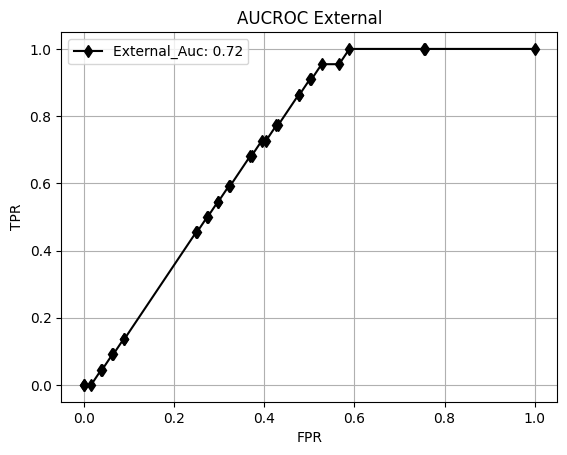

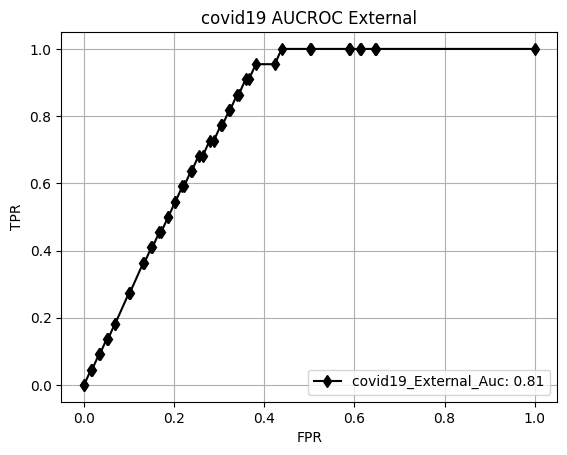

AucROC and aucpr
 0.82 
 0.32 
total P:N ration 1: 12 



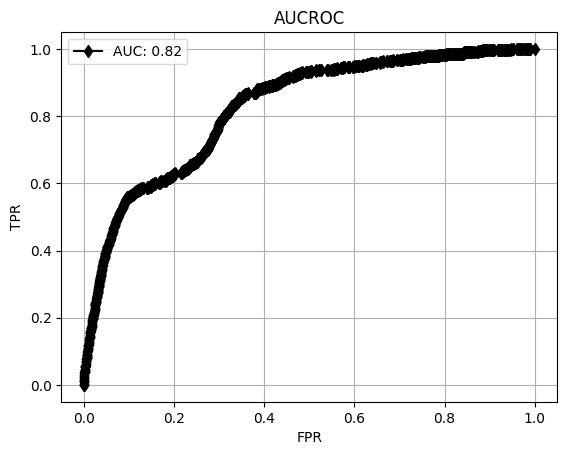

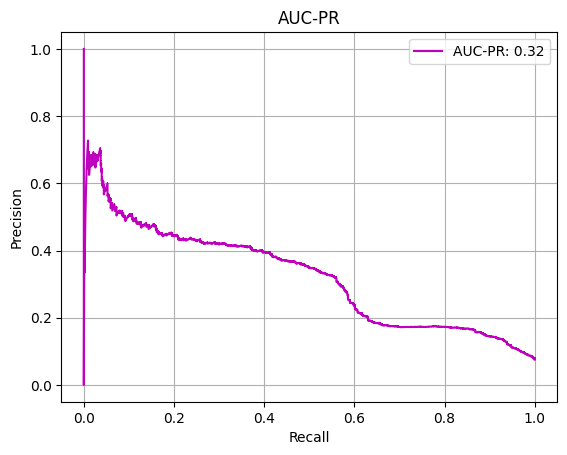

Final average over all folds,Leave one complex out 0.7445 ± 0.1958 0.3312 ± 0.2017


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [13]:
"""
Created on Thu Oct 11 16:31:29 2012
@author: Afsar
This module extracts information from the bound structures involved in a complex
It performs mapping between the sequences of the bound and unbound sequences
which are extracted from their structure files. This is done using global
sequence alignment. This mapping is then used in extracting positive and
negative training examples in getExamplesDBD.py
"""
#from BISEPutils import *
#from myPDBUpdated import *
import Bio.pairwise2
def mapU2B(us, uS2Ri, ulR, bs, bS2Ri, blR):
    """
    Get the mapping of indices between the bound and unbound residues
    us: sequence of the unbound protein
    uS2Ri: seq. to R index list for unbound protein
    ulR: length of R list for the unbound protein
    Similar for the bound protein
    Return: u2b,b2u
    #uR[i] corresponds to bR[u2b[i]] if u2b[i] is not nan
    #bR[i] corresponds to uR[b2u[i]] if b2u[i] is not nan
    """
    u2b = [np.nan for k in range(ulR)]
    b2u = [np.nan for k in range(blR)]
    aln = Bio.pairwise2.align.globalxs(us, bs, -1, -0.1)[0]

    # print aln
    ui = 0
    bi = 0
    for k in range(len(aln[0])):
        uc = aln[0][k]
        bc = aln[1][k]
        if uc == bc:
            u2b[uS2Ri[ui]] = bS2Ri[bi]
            b2u[bS2Ri[bi]] = uS2Ri[ui]
        ui = ui + (uc != '-')
        bi = bi + (bc != '-')
    pu2b = sum(np.isnan(u2b)) / float(len(u2b))
    pb2u = sum(np.isnan(b2u)) / float(len(b2u))
    #    if  pu2b > 0.01:
    #        print "Warning: "+str(pu2b*100)+" % of unbound residues not matched"
    #    if  pb2u > 0.01:
    #        print "Warning: "+str(pb2u*100)+" % of bound residues not matched"
    return (u2b, b2u)


class myPDBComplex:
    """
    Class responsible for extracting information from the bound structures of
    the proteins.
    Attributes:
        fname: list of paths of files constituting the complex
        N: length of fnames
        cid: list of list of chain ids of each file
        R: R[i] is the list of residues (biopython) for file i
        Coords: Coords[i][j] is a list of coordinates of residue R[j] for file i
        seq: seq[i] contains the combination of the peptide sequence
        dthr: distance threshold
        D: D[i][j] is the list of distances between files i and j
    """

    def __init__(self, fnames, dthr=6.0):

        self.fnames = fnames
        self.N = len(fnames)
        self.dthr = dthr

        self.Coords = []
        self.R = []
        self.D = [[[] for i in range(self.N)] for j in range(self.N)]
        self.seq = []
        # self.stx=[]
        self.S2Ri = []
        for (i, f) in enumerate(fnames):
            (_, R, _, seq, S2Ri) = readPDB(f)  #(cid,stx,R,pp,seq,S2Ri)
            #            self.cid.append(cid)
            #self.stx.append(stx)
            self.seq.append(seq)
            self.R.append(R)
            self.S2Ri.append(S2Ri)
            self.Coords.append(getCoords(R))
            for j in range(0, i):
                (self.D[i][j], self.D[j][i]) = getDist(self.Coords[i], self.Coords[j], dthr)

        """
        #Required for ASA computations
        out_file = tempfile.NamedTemporaryFile(suffix='.pair.pdb')
        out_file.close()
        tmpfile=out_file.name
        mergePDBFiles(fnames,tmpfile)

        os.remove(tmpfile)
        """

    def findNforU(self, ufnames):
        """
        returns the distance object but changes the indices to represent the
        mapping between bound and unbound structures
        """
        D = [[[] for i in range(self.N)] for j in range(self.N)]
        U2B = []
        B2U = []
        LenU = []
        for (idx, f) in enumerate(ufnames):
            (_, uR, _, us, uS2Ri) = readPDB(f)
            (bR, bs, bS2Ri) = (self.R[idx], self.seq[idx], self.S2Ri[idx])
            (u2b, b2u) = mapU2B(us, uS2Ri, len(uR), bs, bS2Ri, len(bR))
            LenU.append(len(uR))
            U2B.append(u2b)
            B2U.append(b2u)
        for i in range(self.N):
            for j in range(i + 1, self.N):
                oD = self.D[i][j]
                for k in range(len(oD)):
                    ov = oD[k]
                    vij = (B2U[i][ov[0]], B2U[j][ov[1]], ov[2])
                    vji = (B2U[j][ov[1]], B2U[i][ov[0]], ov[2])
                    D[i][j].append(vij)
                    D[j][i].append(vji)
        return (D, LenU)
import Bio
from Bio.PDB import *
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
#from Bio.Alphabet import IUPAC
import os
def readPDB(fname,name=None):
    """
    Extract info from a PDB file
        fname: path of pdb file
        name: name of the structure (default name of the file without extension)
        return:: (stx,R,pp,seq,S2Ri)

            stx: structure object
            R: list of residues
            pp: list of polypeptides in the structure
            seq: combined sequence (for all polypeptides)
            S2Ri: Sequence to R mapping index list, seq[i] corresponds to
                R[S2Ri[i]]
    """
    stxin=(type(fname)!=type(''))

    if name is None:
        if not stxin:
            (_,name,_)=getFileParts(fname)
        else:
            name=fname.id
    if not stxin:
        stx=PDBParser() .get_structure(name,fname)
    else:
        stx=fname
    if len(stx)>1:
        stx2=Bio.PDB.Structure.Structure(stx.id)
        print (stx2)
        stx2.add(stx[0])
        stx=stx2
    if len(stx)!=1:
        raise ValueError("Unexpected number of structures in "+name)
    #assert len(stx)==1 #there should be only one structure
#    cid=[]
#    for c in stx[0].get_list():
#        cid.append(c.id)
    R=Selection.unfold_entities(stx,'R') #list of residues
    pp=PPBuilder().build_peptides(stx)
    if len(pp)==0:
        pp=CaPPBuilder().build_peptides(stx)
    seq=''.join([p.get_sequence().tostring() for p in pp])
    Rdict=dict(zip(R,range(len(R))))
    S2Ri=[Rdict[r] for p in pp for r in p]
    return (stx,R,pp,seq,S2Ri)
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 04 01:30:15 2012
@author: Afsar
This module contains helper functions.
"""
import os
#from add2path import *
# import pdb
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import pickle
import Bio
from Bio.PDB import *
from Bio import SeqIO
import tempfile
from scipy.sparse import lil_matrix

from Bio.PDB.Polypeptide import one_to_three, three_to_one
import urllib, os, traceback, pdb
from time import time

AA = 'ACDEFGHIKLMNPQRSTVWY-'
to_one_letter_code = {}
aaidx = dict(zip(AA, range(len(AA))))
aa3idx = {}
for __i__, __a__ in enumerate(AA):
    try:
        aa3idx[one_to_three(__a__)] = __i__
        to_one_letter_code[one_to_three(__a__)] = __a__
    except:
        continue

def module_exists(module_name):
    try:
        __import__(module_name)
    except ImportError:
        return False
    else:
        return True
"""
def score_match(pair, matrix=MatrixInfo.blosum62):

    #Given a tuple pair of amino acids, it returns the substitution matrix score


    if pair not in matrix:
        pair = tuple(reversed(pair))
    if pair not in matrix:
        return 0.0
    else:
        return matrix[pair]

def getSubMat(matrix=MatrixInfo.blosum62):
"""
    #Returns a dictionary representation of the columns of a substitution matrix
"""
    M = {}
    for a in AA:
        M[a] = []
        for b in AA:
            M[a].extend([score_match((a, b), matrix)])
    return M


BLOSUM62 = getSubMat()
"""
def getWPSSM(xpm, HWS=5):
    """
    Given a np.array xpm this function creates the windowed representation
    (for use in PSSM, PSFM etc)
    """
    HWS = int(HWS)
    (d, N) = xpm.shape
    pm = np.hstack((np.zeros((d, HWS)), xpm, np.zeros((d, HWS))))
    ws = 2 * HWS + 1
    wpm = np.zeros((ws * d, N))
    for i in range(N):
        wpm[:, i] = pm[:, i:i + ws].flatten('F')
    return wpm


def getSubMatFeats(s, HWS=5):
    """
    Given a sequence, this function returns the subsitution matrix representation
    """
    HWS = int(HWS)
    smat = np.zeros((len(AA), len(s)))
    for (i, a) in enumerate(s):
        try:
            smat[:, i] = BLOSUM62[a]
        except Exception as e:
            print (e)
            continue
    return getWPSSM(smat, HWS)


def renameChainPDB(ifile, oldChainId=' ', newChainId='_', ofile=None):
    """
    Rename chains in pdb and save file
    """
    if ofile is None:
        ofile = ifile
    (stx, _, _, _, _) = readPDB(ifile)
    eids = [c.id for c in stx[0]]
    if type(oldChainId) == type(''):
        oldChainId = [oldChainId]
        newChainId = [newChainId]

    for i, oc in enumerate(oldChainId):
        if oc in eids:
            stx[0][oc].id = newChainId[i]
        else:
            print ("Warning: Chain id \'" + oc + "\' Not found in", ifile)

    io = PDBIO()
    io.set_structure(stx)
    io.save(ofile)


def fetchPDB(i, ofile=None,
             url="http://www.rcsb.org/pdb/download/downloadFile.do?fileFormat=pdb&compression=NO&structureId="):
    """
    Dowload
    Fetches a pdb file for id "i" and puts it in bdir
    """
    if ofile is None or not ofile:
        ofile = './'
    if os.path.isdir(ofile):
        ofile = os.path.join(ofile, i + '.pdb')  # os.path.join(bdir,i+".pdb")
    pdbid = url + str(i)
    with open(ofile, "w") as fh:
        fh.write(urllib.urlopen(pdbid).read())
        fh.flush()
    """
    while(not fh.closed):
        pass

    t0=time();
    while(time()-t0<1.0): #Poll uptil 1 second and make sure that the file downloaded is readable
        try:
            with open(ofile,'rU'):
                break
        except IOError:
            pass
    """
    return ofile


def downloadPDBList(pdblist, bdir):
    """
    Download a list of pdb files
    """
    for i in pdblist:
        print ("Downloading", i)
        try:
            fetchPDB(i, bdir=bdir)
        except Exception as e:
            print ('-' * 60)
            print ('###PROCESSSING FAILED FOR ', i, e)
            traceback.print_exc(file=sys.stdout)
            print ('-' * 60)


def getDSSP(stx, fname):
    """
    Biopython's dssp does not process broken chains (or missing residues). So
    what we do here is to write a temp pdb file for each peptide and apply DSSP
    on it. The return is a dictionary object in which the DSSP proeprties for
    all residues for all chains have been merged.
    """

    class pepSelect(Select):
        """
        Required for selecting the residues within a peptide to write them to a
        file.
        """

        def __init__(self, p):
            self.pL = [r.get_full_id() for r in p]

        def accept_residue(self, res):
            # pdb.set_trace()
            resid = res.get_full_id()  #[:-1]
            if resid in self.pL:
                return 1
            else:
                return 0

    pp = PPBuilder().build_peptides(stx[0])
    io = PDBIO()
    io.set_structure(stx)
    dssp = dict()
    out_file = tempfile.NamedTemporaryFile(suffix='.dssp')
    tmpfname = out_file.name
    out_file.close()
    try:
        for p in pp:
            io.save(tmpfname, pepSelect(p))
            d = DSSP(stx[0], tmpfname)
            dssp = dict(dssp, **d)
    except:
        e = sys.exc_info()[0]
        print (e)
        pdb.set_trace()
        print  ("Oops! Problem running DSSP! Is it installed correctly?")
    finally:
        os.remove(tmpfname)
    return dssp


def getFileParts(fname):
    "Returns the parts of a file"
    (path, name) = os.path.split(fname)
    n = os.path.splitext(name)[0]
    ext = os.path.splitext(name)[1]
    return (path, n, ext)


def getResiId(fid):
    """
    Given the full id of a residue, return the tuple id form
    """
    (_, _, cid, (_, ridx, rinum)) = fid
    return (cid, str(ridx) + rinum.strip())  #


def getResLetter(r2):
    """
    Get the letter code for a biopython residue object
    """
    r2name = r2.get_resname()
    if to_one_letter_code.has_key(r2name):
        scode = to_one_letter_code[r2name]
    else:
        scode = '-'
    return scode


def getSideChainV(r):
    """
    Find the average of the unit vectors to different atoms in the side chain
    from the c-alpha atom. For glycine the average of the N-Ca and C-Ca is
    used.
    Returns (C-alpha coordinate vector, side chain unit vector) for residue r
    """
    u = None
    gly = 0
    if Polypeptide.is_aa(r) and r.has_id('CA'):
        ca = r['CA'].get_coord()
        dv = np.array([ak.get_coord() for ak in r.get_unpacked_list()[4:]])
        if len(dv) < 1:
            if r.has_id('N') and r.has_id('C'):
                dv = []
                dv.append(r['C'].get_coord())
                dv.append(r['N'].get_coord())
                dv = np.array(dv)
                gly = 1
            else:
                # pdb.set_trace()
                return None
        dv = dv - ca
        if gly:
            dv = -dv
        n = np.sum(np.abs(dv) ** 2, axis=-1) ** (1. / 2)
        v = dv / n[:, np.newaxis]
        u = (Vector(ca), Vector(v.mean(axis=0)))
    return u


def getCoords(R):
    """
    Get atom coordinates given a list of biopython residues
    """
    Coords = []
    for (idx, r) in enumerate(R):
        v = [ak.get_coord() for ak in r.get_list()]
        Coords.append(v)
    return Coords


def getDistMat(C0, C1=None):
    """
    for i in range(len(xl)):
    for j in range(len(xr)):
    """
    sym = False
    if C1 is None:
        sym = True
        C1 = C0
    D = np.zeros((len(C0), len(C1)))
    for i in range(len(C0)):
        st = 0
        if sym:
            st = i + 1
        for j in range(st, len(C1)):
            d = spatial.distance.cdist(C0[i], C1[j]).min()
            D[i, j] = d
            if sym:
                D[j, i] = d
    return D


def getDist(C0, C1, thr=np.inf):
    """

    """
    N0 = []
    N1 = []
    for i in range(len(C0)):
        for j in range(len(C1)):
            d = spatial.distance.cdist(C0[i], C1[j]).min()
            # dji=spatial.distance.cdist(C1[j], C0[i]).min()
            #d=min(dij,dji)
            #print d
            if (d < thr):  # and not np.isnan(self.Phi[i]) and not np.isnan(self.Phi[j])
                N0.append((i, j, d))
                N1.append((j, i, d))
    return (N0, N1)


def readFASTA(fname):
    """
    Reads the fasta file fname and returns the sequence only
    """
    handle = open(fname, "rU")
    record = list(SeqIO.parse(handle, "fasta"))
    handle.close()
    if len(record) > 1:
        print ("Warning: Input FASTA file must have only one protein sequence in it. Using only the first sequence.")
    # pdb.set_trace()
    record = record[0]
    return record.seq.tostring().upper()


def readPDB(fname, name=None):
    """
    Extract info from a PDB file
        fname: path of pdb file
        name: name of the structure (default name of the file without extension)
        return:: (stx,R,pp,seq,S2Ri)

            stx: structure object
            R: list of residues
            pp: list of polypeptides in the structure
            seq: combined sequence (for all polypeptides)
            S2Ri: Sequence to R mapping index list, seq[i] corresponds to
                R[S2Ri[i]]
    """
    stxin = (type(fname) != type(''))

    if name is None:
        if not stxin:
            (_, name, _) = getFileParts(fname)
        else:
            name = fname.id
    if not stxin:
        stx = PDBParser().get_structure(name, fname)
    else:
        stx = fname
    if len(stx) > 1:
        stx2 = Bio.PDB.Structure.Structure(stx.id)
        stx2.add(stx[0])
        stx = stx2
    if len(stx) != 1:
        raise ValueError("Unexpected number of structures in " + name)
        # assert len(stx)==1 #there should be only one structure
        # cid=[]
    #    for c in stx[0].get_list():
    #        cid.append(c.id)
    R = Selection.unfold_entities(stx, 'R')  # list of residues
    pp = PPBuilder().build_peptides(stx)
    if len(pp) == 0:
        pp = CaPPBuilder().build_peptides(stx)
    seq = ''.join([p.get_sequence().tostring() for p in pp])
    Rdict = dict(zip(R, range(len(R))))
    S2Ri = [Rdict[r] for p in pp for r in p]

    return (stx, R, pp, seq, S2Ri)


def getSeqFV(stx, R, HWS=10):
    """
    Return a FV based on sequence (uses structure)
    """
    HWS = int(HWS)
    # FV=[[] for x in range(len(R))]
    FV = None
    Rdict = dict(zip(R, range(len(R))))
    first = 1
    #pdb.set_trace()
    for c in stx[0]:
        pp = PPBuilder().build_peptides(c)
        if len(pp) == 0:
            print ("Ignored the empty chain encounted in ", stx.get_full_id())
            continue
        (s, s2r) = getSeqForChain(pp, Rdict)
        s = '-' * HWS + s + '-' * HWS
        idx = 0
        for m in range(HWS, len(s) - HWS):
            if s[m] != '-':
                w = s[m - HWS:m + HWS + 1]
                (pd1, p1) = getPD1Spec(w)
                #pdb.set_trace()
                fv = np.vstack([np.array(pd1.todense()), np.array(p1.todense())])
                if (first):
                    first = 0
                    #create k based on legnth of the vector
                    FV = lil_matrix((fv.shape[0], len(R)))
                FV[:, s2r[idx]] = fv
                idx = idx + 1
    FVF = FV.todense()
    #If no features for the whole residue, set to nan
    FVF[:, np.nonzero(np.array(np.sum(FVF, 0) == 0).ravel())[0]] = np.nan
    FV = lil_matrix(FVF)
    #pdb.set_trace()
    return FV


def getSeqForChain(pp, Rdict):
    """
    For a single chain only!!!
    Get the sequence for a chain and the S2Ri associated with non '-' chars in s
    Remember len(s) is equal to len(S2Ri) iff there are no dashes in s
    """
    s = []
    s.append(pp[0].get_sequence().tostring())
    for idx in range(len(pp) - 1):
        b = pp[idx][-1].id[1] + 1
        e = pp[idx + 1][0].id[1] - 1
        d = '-' * (e - b + 1)
        s.append(d)
        s.append(pp[idx + 1].get_sequence().tostring())
    S2Ri = [Rdict[r] for p in pp for r in p]
    s = ''.join(s)
    return (s, S2Ri)


def getPD1Spec(s, param=None):
    """
    Get 1-spectrum representation of s (ignoring '-'')
    """
    dv = np.sqrt(1 / 20.0)
    V = np.zeros((len(AA), len(s)), dtype='float64')
    for k in range(len(s)):
        if s[k] != '-':
            try:
                V[aaidx[s[k]], k] = V[aaidx[s[k]], k] + 1.0
            except KeyError:
                pass
        else:
            for a in aaidx:
                if a != '-':
                    V[aaidx[a], k] = V[aaidx[a], k] + dv
    # pdb.set_trace()
    #m=np.sqrt(len(s))
    v = V.reshape((np.prod(V.shape), 1))
    v = lil_matrix(v / np.linalg.norm(v))
    v1 = V.sum(axis=1)
    v1 = lil_matrix(v1 / np.linalg.norm(v1)).T
    return (v, v1)


def mergePDBFiles(fnames, ofname):
    ofh = open(ofname, 'w')
    for f in fnames:
        fh = open(f, 'r')
        d = fh.read()
        fh.close()
        ofh.write(d)
    ofh.close()


def copy_dict(d, *keys):
    """Make a copy of only the `keys` from dictionary `d`."""
    return {key: d[key] for key in keys}


def chunks(l, n):
    """ Yield successive n-sized chunks from list l, returns list of lists."""
    for i in xrange(0, len(l), n):
        yield l[i:i + n]


def mergeDicts(Dlist):
    """ merges a list of dictionaries into a single dictionary"""
    dld = {}
    for d in Dlist: dld.update(d)
    return dld


def combineList(l):
    return [item for sublist in l for item in sublist]
import pandas as pd
from scipy import spatial
import numpy as np
from Bio.Data import IUPACData
from Bio.PDB.Polypeptide import *
from os import listdir
#import torch
import pdb
import csv
import json
import pickle
from tqdm import tqdm as tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score,average_precision_score
from Bio import SeqIO
from Bio.SeqIO import FastaIO
from itertools import product
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.preprocessing import normalize
import math
import pickle
def External_GenerateRandomNegativeandBinders(Pdict,posexamples):
    NegtiveRatio=1
    #path='D:/PhD/Inhibitor/InhibitorNewModel2022/'
    path='/content/drive/MyDrive/GNN-PPI-Inhibitor/'
    ###SuperDrugbank
    ###Names
    SuperdrugNames=pd.read_excel(path+'Inhibitor Data/approved_drugs_chemical_structure_identifiers.xlsx',usecols="B").values#'approved_drugs_chemical_structure_identifiers.xlsx'
    SuperdrugNames=SuperdrugNames[1:]
    SuperdrugNames = np.array([s[0] for s in SuperdrugNames])

    df_Superdrug=pd.read_excel(path+'Inhibitor Data/approved_drugs_chemical_structure_identifiers.xlsx',usecols="C").values
    df_Superdrug=df_Superdrug[1:]
    ###
    df_Superdrug_Compounds=np.array([c[0] for c in df_Superdrug])#3638
    SuperDrug_dict=dict (zip (SuperdrugNames,df_Superdrug_Compounds))
    ################
    DBD5_ProteinData_dict=pickle.load(open(path+'NewUbench5InterfaceandSeq_dict.npy',"rb"))
    Ubench5CompNames=list (set (list (DBD5_ProteinData_dict.keys())))
    ####
    Filename=path+'2p2i unique inhibitors.xlsx'
    df=pd.read_excel(Filename)
    Name1='Inhibitor name';Name2=' Inhibitor SMILES'
    Lsetname=df[Name1].values;Inhibitor_SMILES=df[Name2].values;
    Ldict=dict(zip(Lsetname,Inhibitor_SMILES))
    ########
    AllNeg=[];AllPos=[];
    complex_ligand_dict={}
    for i in  range(len(posexamples)):
      complexname,inhibitor=posexamples[i]
      if  getFP(Ldict[inhibitor]) is not None:
          if complexname not in complex_ligand_dict:
              complex_ligand_dict[complexname]=inhibitor#inhibitor for NAME of the inhibitor, Ldict[inhibitor] for smiles
          else:
            #print("else",key,val)
            complex_ligand_dict[complexname]=np.append( complex_ligand_dict.get(complexname, ()) ,inhibitor)#stores names of the inhibitors
#    Complexnames=list (complex_ligand_dict.keys())
    ##############
    totalcomp=list (set (complex_ligand_dict.keys()))
    totalligands_train=[]
    for t in  totalcomp:
        totalligands_train.extend(complex_ligand_dict[t])
    totalligands_train=list (set (totalligands_train))
    """
    Complex,Csr (Compound random from superDrugbank2)
    """
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        origanlL=[getFP(origanlL[t]) is not None for t in range(len(origanlL))]
#        print("everycomp=",everycomp,"origanlL",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        while (len(negs)<NN):# and len(negs)<(len(totalligands_train)-len(origanlL)):
            LigandR = random.choice(SuperdrugNames)
            Npair=((everycomp,LigandR))
            if LigandR  not in origanlL and Npair not in AllNeg and Npair not in AllPos and getFP(SuperDrug_dict[LigandR]) is not None:
                if LigandR==' ' or LigandR==',':
                    1/0
                negs.append(Npair)
#                print("Npair SuperdrugNames",Npair)
        AllNeg.extend(negs)
#        AllPos.extend(pos)
        #####
#    pdb.set_trace()
#    print("N=",len(AllNeg),"P",len(AllPos))
#    print("second method Cr")
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        origanlL=[getFP(origanlL[t]) is not None for t in range(len(origanlL))]
#        print("everycomp=",everycomp,"origanlL",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        while (len(negs)<NN) and len(negs)<(len(totalligands_train)-len(origanlL)):
            if len(totalcomp)>1:
                LigandR = random.choice(totalligands_train)#Lsetname)#
            else:
                LigandR = random.choice(Lsetname)
            Npair=((everycomp,LigandR))#LigandR))
            if LigandR  not in origanlL and Npair not in AllNeg and Npair not in AllPos and getFP(Ldict[LigandR]) is not None:
                if LigandR==' ' or LigandR==',':
                    1/0
                negs.append(Npair)
#                print("Npair",Npair)
        AllNeg.extend(negs)
        AllPos.extend(pos)
#        print("N=",len(AllNeg),"P",len(AllPos))
        ###
        #possiblecomp=list(set (np.array([(Allexamples[t][0]) for t in posexamples])))
        #possiblecomp.remove(everycomp)
#        print("possiblecomp",possiblecomp)
     #####
#    pdb.set_trace()
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        origanlL=[getFP(origanlL[t]) is not None for t in range(len(origanlL))]
#        print("everycomp=",everycomp,"origanlL",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        while (len(negs)<NN):
            for everyL in origanlL:
                ComplexR = random.choice(Ubench5CompNames)
                Npair=((ComplexR,everyL))#everyL))
                if ComplexR!=everycomp and Npair not in AllNeg and Npair not in AllPos:
    #                    print("ComplexR,everycomp)",Npair)
                    negs.append(Npair)

        AllNeg.extend(negs)
        ###################
#    print("N=",len(AllNeg),"P",len(AllPos))
     #####
#    pdb.set_trace()
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        origanlL=[getFP(origanlL[t]) is not None for t in range(len(origanlL))]
#        print("everycomp=",everycomp,"origanlL",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        for everyL in origanlL:
            if len(totalcomp)>1:
                #print("everyL",everyL)
                ComplexR = random.choice(totalcomp)#Complexnames)#
            else:
                ComplexR = random.choice(Complexnames)#
            Npair=((ComplexR,everyL))
            if ComplexR!=everycomp and Npair not in AllNeg and Npair not in AllPos :
#                    print("ComplexR,everycomp)",Npair)
                negs.append(Npair)
        AllNeg.extend(negs)
##    print("N=",len(AllNeg),"P",len(AllPos))
#    fields=['Complexname','Binders SMILES']
#    df=pd.read_csv(path+'Inhibitor Data/BindersWithComplexname.csv', skipinitialspace=True, usecols=fields)
#    # See the keys
#    #print(df.keys())
#    neg_Pidname,neg_smiles=df[df.keys()[0]].values,df[df.keys()[1]].values
#    """
#    New_neg_Pidname,New_neg_smiles=[],[]
#    for s in range(len(neg_smiles)):
#        if getFP(neg_smiles[s]) is None:
#            1/0
#            New_neg_Pidname.append(neg_Pidname[s]),New_neg_smiles.append(neg_smiles[s])
#     """
##    neg_Pid=[n for n in neg_Pidname]#n.split('_')[0]
##    Binders_dict=AppendlistinDict(neg_Pid,neg_smiles)
#    Binders_dict=AppendlistinDict(neg_Pidname,neg_smiles)#for svm pairwise
##    Binders_dict=AppendlistinDict(New_neg_Pidname,New_neg_smiles)
#    Pset = list(set(neg_smiles)) #set of protein sequences#New_
#    pidx = list(range(len(Pset)))
#    Pdict = dict(zip(Pset, pidx)) #seq->index
    ####
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        origanlL=[getFP(origanlL[t]) is not None for t in range(len(origanlL))]
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        if everycomp in Binders_dict:
#            Binders=[(getFP(t) is not None for t in Binders_dict[everycomp])]
            Binders=Binders_dict[everycomp]
            BindersIds=[]
            for t in Binders:
#                print(t,Pdict[t])
                BindersIds.append(Pdict[t])
            Binders_neg=[(everycomp,BindersIds[t]) for t in range(len(Binders))]
            AllNeg.extend(Binders_neg)
            ############################
#            print("everycomp",everycomp,"N Binders=",len(AllNeg),"P",len(AllPos))
            ###############
#    pdb.set_trace()
    #for every binder pick compR from 2p2i
#    for everycomp in totalcomp:
#        origanlL=complex_ligand_dict[everycomp]
##        print("everycomp=",everycomp,"origanlL",len(origanlL))
#        Binders=Binders_dict[everycomp]
#        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
#        NN =NegtiveRatio*len(pos)
#        negs = []
#        while (len(negs)<NN):
#            for everyB in Binders:
#                if getFP(everyB) is not None:
#                    if len(totalcomp)>1:
#                        #print("everyL",everyL)
#                        ComplexR = random.choice(totalcomp)#Complexnames)#
#                    else:
#                        ComplexR = random.choice(Complexnames)#
#                    Npair=((ComplexR,everyB))
#                    if ComplexR!=everycomp and Npair not in AllNeg and Npair not in AllPos:
#        #                    print("ComplexR,everycomp)",Npair)
#                        negs.append(Npair)
#        AllNeg.extend(negs)
#    print(" binder with 2p2i N=",len(AllNeg),"P",len(AllPos))
    ################
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        origanlL=[getFP(origanlL[t]) is not None for t in range(len(origanlL))]
#        print("everycomp=",everycomp,"origanlL",len(origanlL))
        Binders=Binders_dict[everycomp]
        BindersIds=[]
        for t in Binders:
#            print(t,Pdict[t])
            if Pdict[t]==' ' or Pdict[t]==',':
                    1/0
            BindersIds.append(Pdict[t])
#        BindersIds=[(Pdict[t] for t in Binders)]
#        Binders_neg=[(everycomp,BindersIds[t]) for t in range(len(Binders))]
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        while (len(negs)<NN):
#            everyB = random.choice(Binders)
            everyB = random.choice(BindersIds)
            ComplexR = random.choice(Ubench5CompNames)
            Npair=((ComplexR,everyB))
            if ComplexR!=everycomp and Npair not in AllNeg and Npair not in AllPos:
#                print("everyB",Npair)
                negs.append(Npair)
        AllNeg.extend(negs)
#    print("binder with dbd5 N=",len(AllNeg),"P",len(AllPos))
    return np.array(AllPos),np.array(AllNeg)
def AppendlistinDict(list1,list2):
    ####
    from collections import defaultdict
    merge_dict=defaultdict(list);#protein_binders_Namesdict=defaultdict(list);
    # For every complex, save its actual binders
    for (key, value) in zip(list1,list2):#ProteinSeqBinder, Binders_SMILES):#,Binders_names):,Bname)
        if key not in  merge_dict:
            merge_dict[key]=[str(value)]
        else:
            merge_dict[key]=np.append( merge_dict.get(key, ()) , value)
    return merge_dict
def PredictScorefromFileSVM(filename,Pdbloc,trainedModel_IPPI,train_GNN):
  with open(filename) as f:
    D = f.readlines()
  InhibitedComp=[];PdbId=[];Ligandnames=[];SMILES=[];labels=[];
  All_data_list=[]
  from tqdm import tqdm as tqdm
  #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
  for d in tqdm(D):
      #if len(d)==6:
      Pdbid,inhibtedc,Ligandid,smiles = d.split()
      PdbId.append(Pdbid);Ligandnames.append(Ligandid);SMILES.append(smiles);InhibitedComp.append(inhibtedc);#labels.append(float (y));
  ################
  ################
  pdbname=listdir(Pdbloc)
  mypdb=[];External_ProteinData_dict={}
  for p in pdbname:
    if p.split('.pdb')[0] in Pdbid:
      mypdb.append(p)
  UniqueProtein=list (set (mypdb))
  for uniqe in UniqueProtein:
      chains=Struct2chain(Pdbloc+'/'+uniqe)
      Cname_L,seqL,R_L,xl_L=chains[0]
        #############
      Cname_R,seqR,R_R,xl_R=chains[1]
        #####
      LcF=prot_feats_seq(seqL)
      RcF=prot_feats_seq(seqR)
      Complex_AllFeatures=(LcF+RcF)/2#np.hstack((
      External_ProteinData_dict[uniqe]=Complex_AllFeatures
  Result_dict={}
  pos=dict (zip(zip(PdbId, Ligandnames),zip(InhibitedComp,SMILES)))
  Pos,Negs,SuperDrug_dict=External_GenerateRandomNegative(pos)
  poslabel=1.0*np.ones(len(Pos));neglabel=-1.0*np.ones(len(Negs))
  labels=np.append(poslabel,neglabel )
  All_examples=[];All_examples.extend(Pos);All_examples.extend(Negs)
  #All_examples=np.hstack((Pos,Negs))
  #Testing
  DBD5_ProteinData_dict=pickle.load(open(path+'DBD5_ProteinData_dict.pickle',"rb"))
  #Pos_ProteinData_dict=pickle.load(open(path+'ProteinData_dict.pickle',"rb"))
  All_ProteinData_dict=dict( list (External_ProteinData_dict.items())+list (DBD5_ProteinData_dict.items()))
  for d in All_ProteinData_dict:
    data=All_ProteinData_dict[d]
    All_ProteinData_dict[d]=[data[0].cuda(),data[1].cuda(),data[2].cuda(),data[3].cuda()]
  Y_t,Z=[],[]
  for complexname,ligandsmile in All_examples:
    #complexname,Ligandname, ligandsmile,inhibitC =PdbId[nt], Ligandnames[nt], SMILES[nt],InhibitedComp[nt]
    test_score=trainedModel_IPPI(train_GNN,All_ProteinData_dict[complexname],complexname,ligandsmile)
    if test_score!=0.0:
        test_score=test_score.cpu().data.numpy()[0]
        Z.append(test_score)
        Result_dict[(complexname,Ligandname)]=test_score
  return Result_dict,Z,labels
def twomerFromSeq(s):
    k=2
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range (0,len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range (0,len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct,ind))

    V=np.zeros(int((math.pow(7,k))))      #defines a vector of 343 length with zero entries
    try:
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]]+=1
    except:
        count={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
        for q in range(0,len(s)):
            if s[q]=='A' or s[q]=='V' or s[q]=='G':
                count['1']+=1
            if s[q]=='I' or s[q]=='L'or s[q]=='F' or s[q]=='P':
                count['2']+=1
            if s[q]=='Y' or s[q]=='M'or s[q]=='T' or s[q]=='S':
                count['3']+=1
            if s[q]=='H' or s[q]=='N'or s[q]=='Q' or s[q]=='W':
                count['4']+=1
            if s[q]=='R' or s[q]=='K':
                count['5']+=1
            if s[q]=='D' or s[q]=='E':
                count['6']+=1
            if s[q]=='C':
                count['7']+=1
        val=list(count.values()  )           #[ 0,0,0,0,0,0,0]
        key=list(count.keys()     )           #['1', '2', '3', '4', '5', '6', '7']
        m=0
        ind=0
        for t in range(0,len(val)):     #find maximum value from val
            if m<val[t]:
                m=val[t]
                ind=t
        m=key [ind]                     # m=group number of maximum occuring group alphabets in protein
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                if kmer[l] not in groups:
                    c+=m
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]]+=1

    V=V/(len(s)-1)
    return np.array(V)
def threemerFromSeq(s):
    k=3
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range (0,len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range (0,len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct,ind))

    V=np.zeros(int((math.pow(7,k))))      #defines a vector of 343 length with zero entries
    try:
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]]+=1
    except:
        count={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
        for q in range(0,len(s)):
            if s[q]=='A' or s[q]=='V' or s[q]=='G':
                count['1']+=1
            if s[q]=='I' or s[q]=='L'or s[q]=='F' or s[q]=='P':
                count['2']+=1
            if s[q]=='Y' or s[q]=='M'or s[q]=='T' or s[q]=='S':
                count['3']+=1
            if s[q]=='H' or s[q]=='N'or s[q]=='Q' or s[q]=='W':
                count['4']+=1
            if s[q]=='R' or s[q]=='K':
                count['5']+=1
            if s[q]=='D' or s[q]=='E':
                count['6']+=1
            if s[q]=='C':
                count['7']+=1
        val=list(count.values())              #[ 0,0,0,0,0,0,0]
        key=list(count.keys() )              #['1', '2', '3', '4', '5', '6', '7']
        m=0
        ind=0
        for t in range(0,len(val)):     #find maximum value from val
            if m<val[t]:
                m=val[t]
                ind=t
        m=key [ind]                     # m=group number of maximum occuring group alphabets in protein
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                if kmer[l] not in groups:
                    c+=m
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]]+=1

    V=V/(len(s)-1)
    return np.array(V)
def prot_feats_seq(seq):
    #Interfacedict=pickle.load(open(path+"InhibitorNewModel2022/InterfaceFeatures2chainsSVM.npy","rb"))
    #InterfaceF=Interfacedict[complexname]
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    f=[]
    X = ProteinAnalysis(str(seq))
    X.molecular_weight() #throws an error if 'X' in sequence. we skip such sequences
    p=X.get_amino_acids_percent()
    dp=[]
    for a in aa:
        dp.append(p[a])
    dp=np.array(dp)
    dp=normalize(np.atleast_2d(dp), norm='l2', copy=True, axis=1, return_norm=False)
    f.extend(dp[0])

    tm=np.array(twomerFromSeq(str(seq)))
    tm=normalize(np.atleast_2d(tm), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(tm[0])
#    #####
#    thm=np.array(threemerFromSeq(str(seq)))
#    thm=normalize(np.atleast_2d(thm), norm='l2', copy=True, axis=1,return_norm=False)
#    f.extend(thm[0])
    ###
    return np.array(f)
#New start

def GenerateRandomNegative(posexamples,Allexamples,complex_ligand_dict,Ldict):
    NegtiveRatio=1

    ###SuperDrugbank
    ###Names
    SuperdrugNames=pd.read_excel('D:/PhD/Inhibitor/InhibitorNewModel2022/approved_drugs_chemical_structure_identifiers.xlsx',usecols="B").values#'approved_drugs_chemical_structure_identifiers.xlsx'
    SuperdrugNames=SuperdrugNames[1:]
    SuperdrugNames = np.array([s[0] for s in SuperdrugNames])
    ###############
    Filename='D:/PhD/Inhibitor/InhibitorNewModel2022/2p2i unique inhibitors.xlsx'
    df=pd.read_excel(Filename)
    Name1='Inhibitor name';Name2=' Inhibitor SMILES'
    Lsetname=df[Name1].values;Inhibitor_SMILES=df[Name2].values;
    ##########
    totalcomp=Complexnames
    ###########Binders
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        AllPos.extend(pos)
        if everycomp in Binders_dict:
            Binders=Binders_dict[everycomp]
            Binders_neg=[(everycomp,Binders[t]) for t in range(len(Binders))]
            AllNeg.extend(Binders_neg)
    return np.array(AllPos),np.array(AllNeg)
#    c=dict(zip(Lsetname,Inhibitor_SMILES))
    ########benchmark5.5
    benchmark5=listdir("D:/PhD/Inhibitor/InhibitorNewModel2022/benchmark5.5/structures/")
    bench5CompNames=[]

    for b in benchmark5:
        n=b.split('_')
        if len(n)==3:
            bench5CompNames.append(n[0])
    Ubench5CompNames=list (set (bench5CompNames))
    ####
    Complexnames=list (complex_ligand_dict.keys())
    AllNeg=[];AllPos=[];
    totalcomp=list(set (np.array([(Allexamples[t][0]) for t in posexamples])))
    totalligands_train=[]
    for t in  totalcomp:
        totalligands_train.extend(complex_ligand_dict[t])
    totalligands_train=list (set (totalligands_train))
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        print("everycomp=",everycomp,"origanlL",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        while (len(negs)<NN):# and len(negs)<(len(totalligands_train)-len(origanlL)):
            LigandR = random.choice(SuperdrugNames)
            Npair=((everycomp,LigandR))
            if LigandR  not in origanlL and Npair not in AllNeg and Npair not in AllPos and getFP(Ldict[LigandR]) is not None:
                negs.append(Npair)
#                print("Npair SuperdrugNames",Npair)
        AllNeg.extend(negs)
#        AllPos.extend(pos)
        #####
#    pdb.set_trace()
#    print("N=",len(AllNeg),"P",len(AllPos))
#    print("second method Cr")
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        print("everycomp=",everycomp,"origanlL",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        while (len(negs)<NN) and len(negs)<(len(totalligands_train)-len(origanlL)):
            if len(totalcomp)>1:
                LigandR = random.choice(totalligands_train)#Lsetname)#
            else:
                LigandR = random.choice(Lsetname)
            Npair=((everycomp,LigandR))
            if LigandR  not in origanlL and Npair not in AllNeg and Npair not in AllPos and getFP(Ldict[LigandR]) is not None:
                negs.append(Npair)
#                print("Npair",Npair)
        AllNeg.extend(negs)
        AllPos.extend(pos)
#    print("N=",len(AllNeg),"P",len(AllPos))
        ###
        #possiblecomp=list(set (np.array([(Allexamples[t][0]) for t in posexamples])))
        #possiblecomp.remove(everycomp)
#        print("possiblecomp",possiblecomp)
     #####
#    pdb.set_trace()
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        print("everycomp=",everycomp,"origanlL",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        while (len(negs)<NN):
            for everyL in origanlL:
                ComplexR = random.choice(Ubench5CompNames)
                Npair=((ComplexR,everyL))
                if ComplexR!=everycomp and Npair not in AllNeg and Npair not in AllPos:
    #                    print("ComplexR,everycomp)",Npair)
                    negs.append(Npair)

        AllNeg.extend(negs)
        ###################
#    print("N=",len(AllNeg),"P",len(AllPos))
     #####
#    pdb.set_trace()
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        print("everycomp=",everycomp,"origanlL",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        for everyL in origanlL:
            if len(totalcomp)>1:
                #print("everyL",everyL)
                ComplexR = random.choice(totalcomp)#Complexnames)#
            else:
                ComplexR = random.choice(Complexnames)#
            Npair=((ComplexR,everyL))
            if ComplexR!=everycomp and Npair not in AllNeg and Npair not in AllPos:
#                    print("ComplexR,everycomp)",Npair)
                negs.append(Npair)
        AllNeg.extend(negs)
#    print("N=",len(AllNeg),"P",len(AllPos))
    return np.array(AllPos),np.array(AllNeg)

def getFP(s,r = 2,nBits =2048):
    compound = Chem.MolFromSmiles(s.strip())
    if compound is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(compound, r, nBits = nBits)
        #fp = pat.GetAvalonCountFP(compound,nBits=nBits)
        m = np.zeros((0, ), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, m)
        return m
def make_dic():
    prot_dic={}
    letters=IUPACData.protein_letters
    for i in range(len(letters)):
        for j in range(i,len(letters)):
            prot_dic[(letters[i],letters[j])]=0.0
    prot_dic[('_','_')]=0.0# for Amino acids other than 20 natural
    return prot_dic
def extract_feats(dic):
    feats=[]
    key_list=np.load('prote_letter_pair_keys.npy')#to keep features order same
    for key in key_list:
#        pdb.set_trace()
        feats.append(dic[(key[0].decode('utf-8'),key[1].decode('utf-8'))])

    return feats
def generate_pair_features(dist_info,xl,xr):
    prot_dic=make_dic()
#    pdb.set_trace()
    for rec in dist_info:

        try:
            l_letter= three_to_one(xl[rec[0]].get_resname())
            r_letter= three_to_one(xr[rec[1]].get_resname())
#            print(l_letter,l_letter)
            if (l_letter,r_letter) in prot_dic.keys():
                prot_dic[(l_letter,r_letter)]+=1
            elif (r_letter,l_letter) in prot_dic.keys():
                prot_dic[(r_letter,l_letter)]+=1
        except:
            prot_dic[('_','_')]+=1
    return prot_dic
def getDist(C0, C1, thr=np.inf):
    N0 = []
    for i in range(len(C0)):
        for j in range(len(C1)):
            d = spatial.distance.cdist(C0[i], C1[j]).min()
            if (d < thr):  # and not np.isnan(self.Phi[i]) and not np.isnan(self.Phi[j])
                N0.append((i, j, d))
    return N0
def Struct2chain(stx):
    """
    Seq: sequence of the chain
    seq_L:sequence Length
    """
    p = PDBParser()
    L=[]
    stx=p.get_structure('X',stx)
    for model in stx:
        for C in model:
            RL=[]
            for R in C:
                RL.append(R)
            pp=PPBuilder().build_peptides(C)
            if len(pp)==0:
                pp=CaPPBuilder().build_peptides(C)
            seq=''.join([str(p.get_sequence()) for p in pp])
            #seq=''.join([p.get_sequence().tostring() for p in pp])
            seq_L=len(seq)
            L.append((C.full_id[2],seq,seq_L,RL))
    return L
def chainLabel(Cname_T,xl_T,Cname,xl):
    """
    Cname_T: Target chain Name
    xl_T: Target chain co-ordinates
    Cname: Off Target chain Name
    xl: Off Target chain co-ordinates
    """
    tc = getCoords(xl_T)
    nc = getCoords(xl)
    D = getDist(tc, nc, thr = 8.0)
    feats=extract_feats(generate_pair_features(D,xl_T,xl))
    return feats
def InterfaceFeatures(Complexs,pdbloc):
    Found =  listdir(pdbloc)
    InterfaceFeatures=[];InterfaceFeatures=dict(InterfaceFeatures)
    comp_id=list(set(Complexs))
    for ids in range(len(comp_id)):
        if comp_id[ids]+'.pdb' in Found:
            stx=pdbloc+'/'+comp_id[ids]+'.pdb'#'/2XA0.pdb'
            chains=Struct2chain(stx)
            for j in range(len(chains)):
                Cname_T,seq_T,L_T,xl_T=chains[j]
                for k in range(j,len(chains)):
                    Cname,seq,L,xl=chains[k]
                    #if Cname_T!=Cname and Cname!=' 'and Cname_T!=' ':
                    name=comp_id[ids]#+'_'+Cname_T+'_2_'+Cname
                    Interface=chainLabel(Cname_T,xl_T,Cname,xl)
                    InterfaceF=np.array(Interface)
                    InterfaceF=normalize(np.atleast_2d(InterfaceF), norm='l2', copy=True, axis=1, return_norm=False)
                    if name not in InterfaceFeatures.keys():
                        InterfaceFeatures[name]=Interface
    #pickle.dump(InterfaceFeatures, open(path+Filename+"_InterfaceFeatures.npy", "wb"))
    return InterfaceFeatures
def LoadProtein_SVM_Features(UniqueProtein,Pdbloc):
    pdbname=listdir(Pdbloc)
    InterfaceFeatures=[];InterfaceFeatures=dict(InterfaceFeatures)
    SequenceFeatures=[];SequenceFeatures=dict(SequenceFeatures)
    AllFeatures=[];AllFeatures=dict(AllFeatures)
    for  b in range(len(UniqueProtein)):
        if UniqueProtein[b]+'.pdb'in pdbname:
            stx=Pdbloc+UniqueProtein[b]+'.pdb'#directory+'/2XA0.pdb'#
            chains=Struct2chain(stx)
            #########Interface Features
            for j in range(len(chains)):
                Cname_T,seq_T,L_T,xl_T=chains[j]
                for k in range(j,len(chains)):
                    Cname,seq,L,xl=chains[k]
                    #if Cname_T!=Cname and Cname!=' 'and Cname_T!=' ':
                    name=UniqueProtein[b]#+'_'+Cname_T+'_2_'+Cname
                    Interface=chainLabel(Cname_T,xl_T,Cname,xl)
                    seq_TF=prot_feats_seq(seq_T)
                    seq_NTF=prot_feats_seq(seq)
                    SeQFeatures=(seq_TF+seq_NTF)/2
                    InterfaceF=np.array(Interface)
                    InterfaceF=normalize(np.atleast_2d(InterfaceF), norm='l2', copy=True, axis=1, return_norm=False)
                    if name not in InterfaceFeatures.keys():
                        InterfaceFeatures[name]=Interface
                        SequenceFeatures[name]=SeQFeatures
                        AllFeatures[name]=np.append(SeQFeatures,Interface)
    return InterfaceFeatures,SequenceFeatures,AllFeatures
def External_GenerateRandomNegative(path,posexamples):
    NegtiveRatio=1
    ###SuperDrugbank
    ###Names
    SuperdrugNames=pd.read_excel(path+'Data/approved_drugs_chemical_structure_identifiers.xlsx',usecols="B").values#'approved_drugs_chemical_structure_identifiers.xlsx'
    SuperdrugNames=SuperdrugNames[1:]
    SuperdrugNames = np.array([s[0] for s in SuperdrugNames])
    ###############
    ###SuperDrugbank
    df_Superdrug=pd.read_excel(path+'Data/approved_drugs_chemical_structure_identifiers.xlsx',usecols="C").values
    df_Superdrug=df_Superdrug[1:]
    ###
    df_Superdrug_Compounds=np.array([c[0] for c in df_Superdrug])#3638
    SuperDrug_dict=dict (zip (SuperdrugNames,df_Superdrug_Compounds))
    ################
    #path='/content/drive/MyDrive/GNN-PPI-Inhibitor/'
    DBD5_ProteinData_dict=pickle.load(open(path+'Features/NewUbench5InterfaceandSeq_dict.npy',"rb"))
    Ubench5CompNames=list (set (list (DBD5_ProteinData_dict.keys())))
    ####
    AllNeg=[];AllPos=[];
    complex_ligand_dict={}
    for key,val in  posexamples:
      #print(key,val,posexamples[key,val][1])
      if key not in complex_ligand_dict:
        complex_ligand_dict[key]=posexamples[key,val][1]
      else:
        #print("else",key,val)
        complex_ligand_dict[key]=np.append( complex_ligand_dict.get(key, ()) ,posexamples[key,val][1])
    Complexnames=list (complex_ligand_dict.keys())
    totalcomp=list (set (complex_ligand_dict.keys()))
    for everycomp in totalcomp:
        pos=[]
        origanlL=complex_ligand_dict[everycomp]
        #print(origanlL)
        #print("complexname=",everycomp,"origanlInhibitors",len(origanlL))
        for t in range(len(origanlL)):
            if getFP(origanlL[t]) is not None:
                pos.append((everycomp,origanlL[t]))
        #print(pos)
        NN =NegtiveRatio*len(pos)
        negs = []
        AllPos.extend(pos)
        while (len(negs)<NN):# and len(negs)<(len(totalligands_train)-len(origanlL)):
            LigandR = random.choice(SuperdrugNames)
            LigandR_smile=SuperDrug_dict[LigandR]
            Npair=((everycomp,LigandR_smile))
            if LigandR  not in origanlL and Npair not in AllNeg and Npair not in AllPos and getFP(LigandR_smile) is not None:
                negs.append(Npair)
#                print("Npair SuperdrugNames",Npair)
        AllNeg.extend(negs)
    #print("N=",len(AllNeg),"P",len(AllPos))
    #print("second method Cr")
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        print("everycomp=",everycomp,"origanlL",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        while (len(negs)<NN):
            for everyL in origanlL:
                ComplexR = random.choice(Ubench5CompNames)
                Npair=((ComplexR,everyL))
                if ComplexR!=everycomp and Npair not in AllNeg and Npair not in AllPos and getFP(everyL) is not None:
    #                    print("ComplexR,everycomp)",Npair)
                    negs.append(Npair)
        AllNeg.extend(negs)
        ###################
    #print("N=",len(AllNeg),"P",len(AllPos))
    return np.array(AllPos),np.array(AllNeg),SuperDrug_dict
def PredictScorefromFileSVM(path,filename,Pdbloc,trainedModel_SVM,Ptr,Ctr,Pscaler, Cscaler):
#  path,filename,Pdbloc,trainedModel_SVM,Ptr,Ctr,Pscaler, Cscaler=path,path+'/HansonACE2hits.txt',path+'/External data for Inhibitors/protein pdb/',clf,Ptr,Ctr,Pscaler, Cscaler
#  path,path+'/2dhy_all_pos.txt',path+'/External data for Inhibitors/protein pdb/',clf,Ptr,Ctr,Pscaler, Cscaler)#(filename,Pdbloc,trainedModel_SVM,Ptr,Ctr)
  with open(filename) as f:
    D = f.readlines()
  InhibitedComp=[];PdbId=[];Ligandnames=[];SMILES=[];labels=[];
  All_data_list=[]
  from tqdm import tqdm as tqdm
  #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
  for d in tqdm(D):
      #if len(d)==6:
      Pdbid,inhibtedc,Ligandid,smiles = d.split()
      PdbId.append(Pdbid);Ligandnames.append(Ligandid);SMILES.append(smiles);InhibitedComp.append(inhibtedc);#labels.append(float (y));
  ################
  #path='D:/PhD/Inhibitor/InhibitorNewModel2022/'
  #githubpath='/content/PPI-Inhibitors/'
  ################
  pdbname=listdir(Pdbloc)
  mypdb=[]
  for p in pdbname:
    p=p.split('.pdb')[0]
    if  p in Pdbid:
      mypdb.append(p)
  UniqueProtein=list (set (mypdb))
  proteindataFilename=filename.split('/')[-1].split('.txt')[0]
  #print(proteindataFilename)
  #/content/PPI-Inhibitors/Features/2dyh_all_External_ProteinData_dict.txt
  External_AllFeatures=pickle.load(open(path+'Features/'+proteindataFilename+'_External_ProteinData_dict.npy',"rb"))
  labels_All=[];Z=[]
  pos=dict (zip(zip(PdbId, Ligandnames),zip(InhibitedComp,SMILES)))

  Pos,Negs,SuperDrug_dict=External_GenerateRandomNegative(path,pos)
  poslabel=1.0*np.ones(len(Pos));neglabel=-1.0*np.ones(len(Negs))
  labels=np.append(poslabel,neglabel )
  All_examples=[];All_examples.extend(Pos);All_examples.extend(Negs)
  #Testing
  DBD5_SVM_ProteinData_dict=pickle.load(open(path+'Features/NewUbench5InterfaceandSeq_dict.npy',"rb"))
  #Pos_ProteinData_dict=pickle.load(open(path+'ProteinData_dict.pickle',"rb"))
  All_ProteinData_dict=dict( list (External_AllFeatures.items())+list (DBD5_SVM_ProteinData_dict.items()))
  Ctt,Ptt=[],[]
  for complexname,ligandsmile in All_examples:
    if getFP(ligandsmile) is not None:
        Ptt.append(All_ProteinData_dict[complexname])
        Ctt.append(getFP(ligandsmile))
#        labels.append(labels)
  ##########
  Ptt,Ctt = Pscaler.transform(Ptt), Cscaler.transform(Ctt)
  Kp = kernel(Ptt,Ptr)
  Kc = kernel(Ctt,Ctr)
  Ktt= Kp*Kc
  test_score= trainedModel_SVM.decision_function(Ktt)
  Z.extend(test_score);labels_All.extend(labels)
#  Result_dict=dict (zip( All_examples,Z))
  return Z,labels
def LoadSuperDrugdata(path):
  #path='/content/PPI-Inhibitors/Data/'
  import pandas as pd
  df_Superdrug=pd.read_excel(path+'Data\approved_drugs_chemical_structure_identifiers.xlsx',usecols="C").values#index_col=2)
  df_Superdrug=df_Superdrug[1:]
  ###Names
  SuperdrugNames=pd.read_excel(path+'Data\approved_drugs_chemical_structure_identifiers.xlsx',usecols="B").values#index_col=2)
  SuperdrugNames=SuperdrugNames[1:]
  SuperdrugNames=np.array([c[0] for c in SuperdrugNames])
  df_Superdrug_Compounds_SMILES=np.array([c[0] for c in df_Superdrug])#3638
  #CompoundFeatures = np.array([getFP(s) for s in df_Superdrug_Compounds])
  return df_Superdrug_Compounds_SMILES,SuperdrugNames
def Calculate_RFPP(z,Targetlabels):
  RPP=[]
  index_P=np.argsort(z)
  n=len(Targetlabels)
  z=np.array(z)
  sorted_index=index_P[::-1][:n]
  sorted_score=z[index_P[::-1][:n]]
  sorted_Targetlabels=Targetlabels[sorted_index]
  ###
  RPP.append(np.where(sorted_Targetlabels==1))
  RFPP=np.min(RPP)+1
  return RFPP
def PredictRFPPfromFile(path,filename,Pdbloc,trainedModel_SVM,Ptr,Ctr,Pscaler, Cscaler):
#filename,Pdbloc,trainedModel_IPPI,train_GNN=Externalpath+'2dyh_all.txt',Externalpath+'pdb/',IPPI_Net,GNN_model
#  path,filename,Pdbloc,trainedModel_SVM,Ctr,Ptr,Pscaler, Cscaler=path,path+'/2dhy_all_pos.txt',path+'/External data for Inhibitors/protein pdb/',clf,Ptr,Ctr,Pscaler, Cscaler
  with open(filename) as f:
    D = f.readlines()
  InhibitedComp=[];PdbId=[];Ligandnames=[];SMILES=[];labels=[];
  All_data_list=[]
  from tqdm import tqdm as tqdm
  #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
  for d in tqdm(D):
      #if len(d)==6:
      Pdbid,inhibtedc,Ligandid,smiles = d.split()
      PdbId.append(Pdbid);Ligandnames.append(Ligandid);SMILES.append(smiles);InhibitedComp.append(inhibtedc);#labels.append(float (y));
  ################
  ################
  pdbname=listdir(Pdbloc)
  mypdb=[]
  for p in pdbname:
    #print (p)
    p=str(p).split('.pdb')[0]
    if p in Pdbid:
      mypdb.append(p)
  UniqueProtein=list (set (mypdb))
  ##############
  proteindataFilename=filename.split('/')[-1].split('.txt')[0]
  External_AllFeatures=pickle.load(open(path+proteindataFilename+'_External_ProteinData_dict.npy',"rb"))
#  if len(filename.split('/')) >1:
#      proteindataFilename=filename.split('/')[-1].split('.txt')[0]
#  if proteindataFilename+'_External_ProteinData_dict.npy' in path:
#      External_AllFeatures=pickle.load(open(path+proteindataFilename+'_External_ProteinData_dict.npy',"rb"))
#  else:
#      print ("ComputIing protein features")
#      InterfaceFeatures,SequenceFeatures,External_AllFeatures=LoadProtein_SVM_Features(UniqueProtein,Pdbloc)
#      pickle.dump(External_AllFeatures,open(path+proteindataFilename+'_External_ProteinData_dict.npy',"wb"))
##  External_ProteinData_dict=pickle.load(open(path+'2dhy_all_pos_External_ProteinData_dict.npy',"rb"))
###  External_ProteinData_dict=PrepairDataset.processProtein(UniqueProtein,Pdbloc)
##  #Result_dict={}
  External_ProteinData_dict=External_AllFeatures
#  pos=dict (zip(zip(PdbId, Ligandnames),zip(InhibitedComp,SMILES)))
  pos={}
  for index in range (len(SMILES)):
      pos[(PdbId[index], Ligandnames[index])]=(InhibitedComp[index],SMILES[index])
  #########
  Superdrug_SMILES,SuperdrugNames=LoadSuperDrugdata(path)
  ####P2C_dict is the protein paired with all compounds in positive set
  from collections import defaultdict
  P2C_dict={}#defaultdict(list)
  for (key, val) in pos:
    #key,value=Pset[key],Cset[value]
    if key not in P2C_dict:
      P2C_dict[key]=pos[key,val][1]
    else:
      P2C_dict[key]=np.append(P2C_dict.get(key, ()) , pos[key,val][1])
  ##########loop
  """
  for d in External_ProteinData_dict:
    data=External_ProteinData_dict[d]
    External_ProteinData_dict[d]=[data[0].cuda(),data[1].cuda(),data[2].cuda(),data[3].cuda()]
  """
  Y_t,Z,Targrtlabels=[],[],[]
  RFPP_all=[];Result_All=[];Targetlabels_All=[];
  perntile_values = [0,1,5,10,20,40,50,60,70,80,90,95,99,100]#99
  for Pi in P2C_dict:
    ####For one example Pi
    Pi_Feature=External_ProteinData_dict[Pi]#P features of that index
    Actual_Compound=P2C_dict[Pi]#Actul_Compound paired with Pi
    #Actual_Compound_Features=np.array([U[c] for c in Actual_Compound])
    Cseq=[];Cseq.extend(Actual_Compound);Cseq.extend(Superdrug_SMILES)#Features all unique Compounds of Superdrugbank and truepositive examples
    Ptt=[];Ctt=[];#np.array([Pi_Feature for i in range(len(Ctt))])#Copy same feature of protein equal to number of unique compounds
    for smile in Cseq:
        if getFP(smile)  is not None:
            Ctt.append(getFP(smile))
            Ptt.append(Pi_Feature)
    ########
    Names=[];Names.extend(Ligandnames);Names.extend(SuperdrugNames)
    #All_examples=dict(zip(Ptt,Ctt))
    poslabel=1.0*np.ones(len(Actual_Compound));neglabel=-1.0*np.ones(len(Superdrug_SMILES))
    Targetlabels=np.append(poslabel,neglabel )
    ##########
    Ptt,Ctt = Pscaler.transform(Ptt), Cscaler.transform(Ctt)
    Kp = kernel(Ptt,Ptr)
    Kc = kernel(Ctt,Ctr)
    Ktt= Kp*Kc
    Z= trainedModel_SVM.decision_function(Ktt)
    RFPP=Calculate_RFPP(Z,Targetlabels)
    #print(RFPP)
    #Result_dict=dict (zip(All_examples,test_score))
    #RFPP=Calculate_RFPP(z_random,Targetlabels)
    RFPP_all.append(RFPP)#;Targetlabels_All.extend(Targetlabels);Result_All.extend(Z);
  return RFPP_all
def all_non_consecutive(arr):
    ans = []
    start = arr[0]
    index = 0
    for number in arr:
        if start == number:
            start += 1
            index += 1
            continue

        ans.append({'i': index, 'n': number})
        start = number + 1
        index += 1
    return ans
if __name__=="__main__":
    #path='D:/PhD/Inhibitor/InhibitorNewModel2022/'
    path='/content/drive/MyDrive/GNN-PPI-Inhibitor/'
    githubpath='/content/PPI-Inhibitors/'
    Ubench5InterfaceandSeq_dict=pickle.load(open(githubpath+'Features/NewUbench5InterfaceandSeq_dict.npy',"rb"))
    Pos_seqandInterfaceF_dict=pickle.load(open(githubpath+'Features/Pos_seqandInterfaceF_dict.npy',"rb"))
    Complex_AllFeatures_dict=dict( list (Pos_seqandInterfaceF_dict.items())+list (Ubench5InterfaceandSeq_dict.items()))
    # Filename=path+'2p2i unique inhibitors.xlsx'
    # df=pd.read_excel(Filename)
    # Name1='Inhibitor name';Name2=' Inhibitor SMILES'
    # Lsetname=df[Name1].values;Inhibitor_SMILES=df[Name2].values;
    # Ldict=dict(zip(Lsetname,Inhibitor_SMILES))


    # === REPLACEMENT CODE BLOCK ===
# The original '.xlsx' file is missing from the repository.
# This code loads the same data from '2p2iInhibitorsSMILES.txt' instead.

Lsetname = []
Inhibitor_SMILES = []

# Define the path to the file that actually exists
filepath = '/content/PPI-Inhibitors/Data/2p2iInhibitorsSMILES.txt'

with open(filepath, 'r') as f:
    for line in f:
        parts = line.strip().split()
        # Based on the file format, the inhibitor name is the 2nd item
        # and the SMILES string is the 5th item.
        if len(parts) >= 5:
            inhibitor_name = parts[1]
            smiles_string = parts[4]
            Lsetname.append(inhibitor_name)
            Inhibitor_SMILES.append(smiles_string)

    print(f"Successfully loaded {len(Lsetname)} inhibitors from 2p2iInhibitorsSMILES.txt")

    #/content/PPI-Inhibitors/Data/2p2iInhibitorsSMILES.txt
    with open(githubpath+'Data/2p2iInhibitorsSMILES.txt') as f:#30May
        D = f.readlines()
    C=[];P=[];Y=[];Cseq=[];Pseq=[]
    Ids=[];Ligandnames=[];Complexs=[];SMILESlist=[];
    Inhibitedcomplexs=[]
    Ldict = set(Lsetname)
    for d in tqdm(D):
      Id,Inhibitedcomp,Complex,Ligandname,SMILES,y = d.split()
      # if Ligandname in Ldict:
      Ids.append(Id);Ligandnames.append(Ligandname);Complexs.append(Complex);SMILESlist.append(SMILES);Inhibitedcomplexs.append(Inhibitedcomp);Y.append(y)
    from collections import defaultdict
    complex_ligand_dict=defaultdict(list)
    AllCompoundslist=[]
    Ldict=dict (zip(Ligandnames,SMILESlist))
   # For every complex, save its actual ligand
    for (key, value) in zip(Ids, Ligandnames):
        if getFP(Ldict[value]) is not None:
          if key not in complex_ligand_dict:
            complex_ligand_dict[key]=[value]
          else:
            complex_ligand_dict[key]=np.append(complex_ligand_dict.get(key, ()) , value)
    ###SuperDrugbank
    df_Superdrug=pd.read_excel(githubpath+'Data/approved_drugs_chemical_structure_identifiers.xlsx',usecols="C").values
    df_Superdrug=df_Superdrug[1:]
    ###Names
    SuperdrugNames=pd.read_excel(githubpath+'Data/approved_drugs_chemical_structure_identifiers.xlsx',usecols="B").values#'approved_drugs_chemical_structure_identifiers.xlsx'
    SuperdrugNames=SuperdrugNames[1:]
    SuperdrugNames = np.array([s[0] for s in SuperdrugNames])
    SuperdrugNames = np.append(SuperdrugNames,Ligandnames)#Lsetname)
     ###
    df_Superdrug_Compounds=np.array([c[0] for c in df_Superdrug])#3638
    for s in range(len( df_Superdrug_Compounds)):
        Ldict[SuperdrugNames[s]]=df_Superdrug_Compounds[s]
    ###Binders
    fields=['Complexname','Binders SMILES']
    df=pd.read_csv(githubpath+'Data/BindersWithComplexname.csv', skipinitialspace=True, usecols=fields)
    neg_Pidname,neg_smiles=df[df.keys()[0]].values,df[df.keys()[1]].values
    Binders_dict=AppendlistinDict(neg_Pidname,neg_smiles)
    Bset = list(set(neg_smiles)) #set of protein sequences
    Bidx = list(range(len(Bset)))
    Bseq2ids= dict(zip(Bset, Bidx)) #seq->index
    Bids2seq = dict(zip(Bidx,Bset)) #index->seq
    for b in Bids2seq:
        Ldict[str (b)]=Bids2seq[b]
    CompoundFingerprintFeaturesDict=pickle.load(open(githubpath+'Features/Compound_Fingerprint_Features_Dict.npy',"rb"))
    Z = []; Yo = []; A = [];Yp=[]
    AUC_ROC_final=[];Precision_final=[];Recall_final=[];Avg_P_final=[];
    #############
    comp=dict(zip(zip (Ids,Ligandnames),zip(Ids,SMILESlist)))
    from sklearn.model_selection import GroupKFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import normalize
    from sklearn.metrics.pairwise import rbf_kernel as kernel
    from sklearn.svm import LinearSVC,SVC
    import pandas as pd
    import random
    from sklearn.metrics import auc,precision_recall_curve
    CC=comp.keys()
    CC=list(CC);KK=[]
    [KK.append(k[0].split('_')[0]) for k in CC]
    groups = pd.DataFrame(KK)
    gkf = GroupKFold(n_splits=len(set (KK)))
    ###########
    Testlen=0
#    WriteAllexamplesRandomBindersAll=open(path+'WriteAllexamplesRandomBindersIdsAll_6JAN.txt', 'w')
#    WriteAllexamplesRandomBindersAll=open(path+'WriteAllexamplesRandomBindersIdsAll_6JAN_Second.txt', 'r')
    #with open(path+'WriteAllexamplesRandomBindersIdsAll_6JAN_Second.txt') as f:#30May
    with open(githubpath+'Data/WriteAllexamplesRandomBindersIdsAll_24JAN.txt') as f:
#    WriteAllexamplesRandomBindersIdsAll_6JAN
        D = f.readlines()
    Labels=[];Ligandnames=[];Complexs=[];#SMILESlist=[];
    TestPoscomplexes=[]
    for d in tqdm(D):
      if len(d.split())==4:
          TestPoscomp,Complexname,Ligandname,label = d.split()
      else:
          TestPoscomp,Complexname,Ligandname,label = d.split()[0],d.split()[1],(' ').join(d.split()[2:-1]),d.split()[-1]
      TestPoscomplexes.append(TestPoscomp),Ligandnames.append(Ligandname);Complexs.append(Complexname);Labels.append(float (label))
    #########
    Allexamples=dict (zip(zip(TestPoscomplexes,zip(Complexs,Ligandnames)),Labels))
#    KK=[]
    Alldata=list (Allexamples.keys())
    KK=[k[0].split('_')[0] for k in Alldata]
    groups = pd.DataFrame(KK)
    gkf = GroupKFold(n_splits=len(set (KK)))
    ###########
    AlltestExamples=[];Externallabels=[];ExternalscoresLOCO=[];covid19_Externallabels=[];covid19_ExternalscoresLOCO=[];
    Complexnames=list (complex_ligand_dict.keys())
    Labels=np.array(Labels)
    Complexs,Ligandnames=np.array(Complexs),np.array(Ligandnames)
#    prev=0;
#    for gc in gamma:
#        for gp in gamma:
    for trainindex, testindex in gkf.split(KK, KK, groups=groups):
        Alldata=list (Allexamples.keys());Alldata=np.array(Alldata, dtype=object)
        train,test=Alldata[trainindex],Alldata[testindex]
        AlltestExamples.extend(test)
        Ctr=[];Ptr=[];y_train=[];
        for t in train:
            Ctr.append(CompoundFingerprintFeaturesDict[t[1][1]]);Ptr.append( Complex_AllFeatures_dict[t[1][0]]);y_train.append(Allexamples[t[0],t[1]])
        Pscaler = StandardScaler().fit(Ptr)
        Cscaler = StandardScaler().fit(Ctr)
        Ptr,Ctr = Pscaler.transform(Ptr), Cscaler.transform(Ctr)
        ########33
        Kp = kernel(Ptr)#,gamma=1.0)
        Kc = kernel(Ctr)#,gamma=1.0)

        Ktr = Kp*Kc#for checking only
        clf = SVC(C = 1.0, kernel = 'precomputed',class_weight='balanced')
        clf.fit(Ktr,y_train)

        Ctt=[];Ptt=[];y_test=[]
        for t in test:
            Ctt.append(CompoundFingerprintFeaturesDict[t[1][1]]);Ptt.append( Complex_AllFeatures_dict[t[1][0]]);y_test.append(Allexamples[t[0],t[1]])
        Testlen=Testlen+len(test)
        print ("Testlen",len(test),"train length",len(train))
        Ptt,Ctt = Pscaler.transform(Ptt), Cscaler.transform(Ctt)
        Kp = kernel(Ptt,Ptr)
        Kc = kernel(Ctt,Ctr)
#        Ktt_test= Kptest*Kctest#for checking only
        Ktt = (Kp*Kc)#**2# (Kp**2+Kc**2+2*Kp*Kc)Kp*Kc#
        z = clf.decision_function(Ktt)
        yp=clf.predict(Ktt)
        Auc = roc_auc_score(y_test, z)
        average_P_score=average_precision_score(y_test, z)
#        print("\nfold Auc:",Auc,"average_P_score=",average_P_score ,"P",len(testPos),"N",len(testNeg))
        print(t[0],"\t",round (Auc,3),"\t",round (average_P_score,3))# ,"\t",len(),"\t",len(testNegcomp),"\t",round (len(testNegcomp) /len(testPoscomp),1))
#        pdb.set_trace()
        AUC_ROC_final.append(Auc);Avg_P_final.append(average_P_score);
        Z.extend(list(z));Yo.extend(list(y_test))#;Yp.extend(list(yp))
        #######################3
        #/content/PPI-Inhibitors/Data/External data/2dyh_all.txt#githubpath+'/Data/External data/2dyh_all.txt
        #RFPP_all=PredictRFPPfromFile(githubpath,githubpath+'/Data/External data/2dyh_all.txt',githubpath+'/Data/External data/pdb/',clf,Ptr,Ctr,Pscaler, Cscaler)#(filename,Pdbloc,trainedModel_SVM,Ctr,Ptr)
        External_score,External_labels=PredictScorefromFileSVM(githubpath,githubpath+'/Data/External data/2dyh_all.txt',githubpath+'/Data/External data/pdb/',clf,Ptr,Ctr,Pscaler, Cscaler)#(filename,Pdbloc,trainedModel_SVM,Ptr,Ctr)
        ExternalscoresLOCO.extend(External_score);Externallabels.extend(External_labels)
        External_Auc= roc_auc_score(External_labels, External_score)
        External_AP=average_precision_score(External_labels, External_score)
        print("External_Auc,PR,RFPP",round (External_Auc,3), round (External_AP,3))#,RFPP_all,"\n")
        #########
        #Covid19_RFPP_all=PredictRFPPfromFile(githubpath,githubpath+'/Data/External data/HansonACE2hits.txt',githubpath+'/Data/External data/pdb/',clf,Ptr,Ctr,Pscaler, Cscaler)#(filename,Pdbloc,trainedModel_SVM,Ctr,Ptr)
        Covid19_External_score,Covid19_External_labels=PredictScorefromFileSVM(githubpath,githubpath+'/Data/External data/HansonACE2hits.txt',githubpath+'/Data/External data/pdb/',clf,Ptr,Ctr,Pscaler, Cscaler)#(filename,Pdbloc,trainedModel_SVM,Ptr,Ctr)
        covid19_Externallabels.extend(Covid19_External_labels);covid19_ExternalscoresLOCO.extend(Covid19_External_score)
        Covid19_External_Auc= roc_auc_score(Covid19_External_labels, Covid19_External_score)
        Covid19_External_AP=average_precision_score(Covid19_External_labels, Covid19_External_score)
        print("Covid19_External_Auc,PR,RFPP",round (Covid19_External_Auc,3), round (Covid19_External_AP,3))#,Covid19_RFPP_all,"\n")
    #####
    External_fpr, External_tpr, External_thresholds = roc_curve(Externallabels,ExternalscoresLOCO)
    External_Auc = roc_auc_score(Externallabels,ExternalscoresLOCO)
    External_Auc=(External_Auc).round(2)
    fig = plt.figure()
    plt.plot(External_fpr, External_tpr,color='k',marker='d',label='External_Auc:{: .2f}'.format(External_Auc))
    plt.title('AUCROC External');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.legend();plt.show();
    fig .savefig(path+"AUCROC External SVM PPI Inhibitors Random and Binders combine Negative.pdf", bbox_inches='tight')
    ########
    covid19_External_fpr, covid19_External_tpr, covid19_External_thresholds = roc_curve(covid19_Externallabels,covid19_ExternalscoresLOCO)
    covid19_External_Auc = roc_auc_score(covid19_Externallabels,covid19_ExternalscoresLOCO)
    covid19_External_Auc=(covid19_External_Auc).round(2)
    fig = plt.figure()
    plt.plot(covid19_External_fpr, covid19_External_tpr,color='k',marker='d',label='covid19_External_Auc:{: .2f}'.format(covid19_External_Auc))
    plt.title('covid19 AUCROC External');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.legend();plt.show();
    fig .savefig(path+"AUCROC covid19 External SVM PPI Inhibitors Random and Binders combine Negative.pdf", bbox_inches='tight')
    ########
    fpr, tpr, thresholds = roc_curve(Yo, Z)
    Auc = roc_auc_score(Yo, Z)
    Auc=(Auc).round(2)
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(Yo, Z)
    aucpr=auc(recall,precision)
    aucpr=(aucpr).round(2)
    #####
    Yo=np.array(Yo)
    print("AucROC and aucpr\n",Auc,"\n",aucpr,"\ntotal P:N ration 1:",int (np.sum([Yo==-1.0])/np.sum([Yo==1.0])),"\n")
    ######
    fig = plt.figure()
    plt.plot(fpr,tpr,color='k',marker='d',label='AUC:{: .2f}'.format(Auc))
    plt.title('AUCROC');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.legend();plt.show();
    fig .savefig(path+"AUCROC SVM PPI Inhibitors Random and Binders combine Negative.pdf", bbox_inches='tight')
    ###
    precision, recall, thresholds = precision_recall_curve(Yo, Z)
    aucpr=average_precision_score (Yo, Z)
    ######
    fig = plt.figure()
    plt.plot(recall,precision,color='m',marker=',',label='AUC-PR:{: .2f}'.format(aucpr))
    plt.title('AUC-PR');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid();plt.legend();plt.show();
    fig .savefig(path+"AUC-PR PPI Inhibitors  Random and Binders combine.pdf", bbox_inches='tight')
    print("Final average over all folds,Leave one complex out",np.average(AUC_ROC_final).round(4),'±',np.std( AUC_ROC_final).round(4),np.average(Avg_P_final).round(4),'±',np.std( Avg_P_final).round(4))
    # 1/0
    # InterfaceFeatures(Complexs,Filename,path,pdbloc)

    # 1/0
    LsetFeature_dict=dict(zip(Lsetname,Inhibitor_SMILES))
    AlltestExamplesInhibitorScores_dict={}
    Labels=[]
    for t in range (len(AlltestExamples)):
        I=(AlltestExamples[t][1])
#        print(AlltestExamples[t],AlltestExamples[t][1],"\n")
        if I not in AlltestExamplesInhibitorScores_dict:#and I not in LsetFeature_dict and Yo[t]==-1.0:
            if I in LsetFeature_dict:
                Label=1.0
            else:
                Label=-1.0
            Labels.append(Label)
            AlltestExamplesInhibitorScores_dict[I]=(Z[t],Label)
        else:
            AlltestExamplesInhibitorScores_dict[I]=np.max(np.asarray(AlltestExamplesInhibitorScores_dict[I][0],Z[t])),AlltestExamplesInhibitorScores_dict[I][1]
    ########################
    Pscores,Plabels=[],[]

    for ee in AlltestExamplesInhibitorScores_dict:
        Pscore,Plabel=AlltestExamplesInhibitorScores_dict[ee]
        Pscores.append(Pscore),Plabels.append(Plabel)
    fpr, tpr, thresholds = roc_curve(Plabels,Pscores)
    AucProteinIndependent = roc_auc_score(Plabels,Pscores)
    AucProteinIndependent=(AucProteinIndependent).round(2)
    # calculate precision-recall curve
#    precision, recall, thresholds = precision_recall_curve(Yo, Z)
#    aucpr=auc(recall,precision)
#    aucpr=(aucpr).round(2)
#    auc = roc_auc_score(Yo, Z)
    #####
#    Yo=np.array(Yo)
#    print("AucROC and aucpr\n",Auc,"\n",aucpr,"\ntotal P:N ration 1:",int (np.sum([Yo==-1.0])/np.sum([Yo==1.0])),"\n")
    ######
    fig = plt.figure()
    plt.plot(fpr,tpr,color='b',marker='*',label='AUC Protein Independent:{: .2f}'.format(AucProteinIndependent))
    plt.title('AUCROC ProteinIndependent');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.legend();plt.show();
    fig .savefig(path+"PPI Inhibitors AucProteinIndependent.pdf", bbox_inches='tight')